# **Table Detection and Extraction From Image Project**

# **Step 1 : Detecting the table**

**Installing required dependencies**


In [ ]:
# Installing tesseract in system
#!sudo apt install tesseract-ocr-fra
#!pip install pytesseract transformers ultralyticsplus==0.0.23 ultralytics==8.0.21

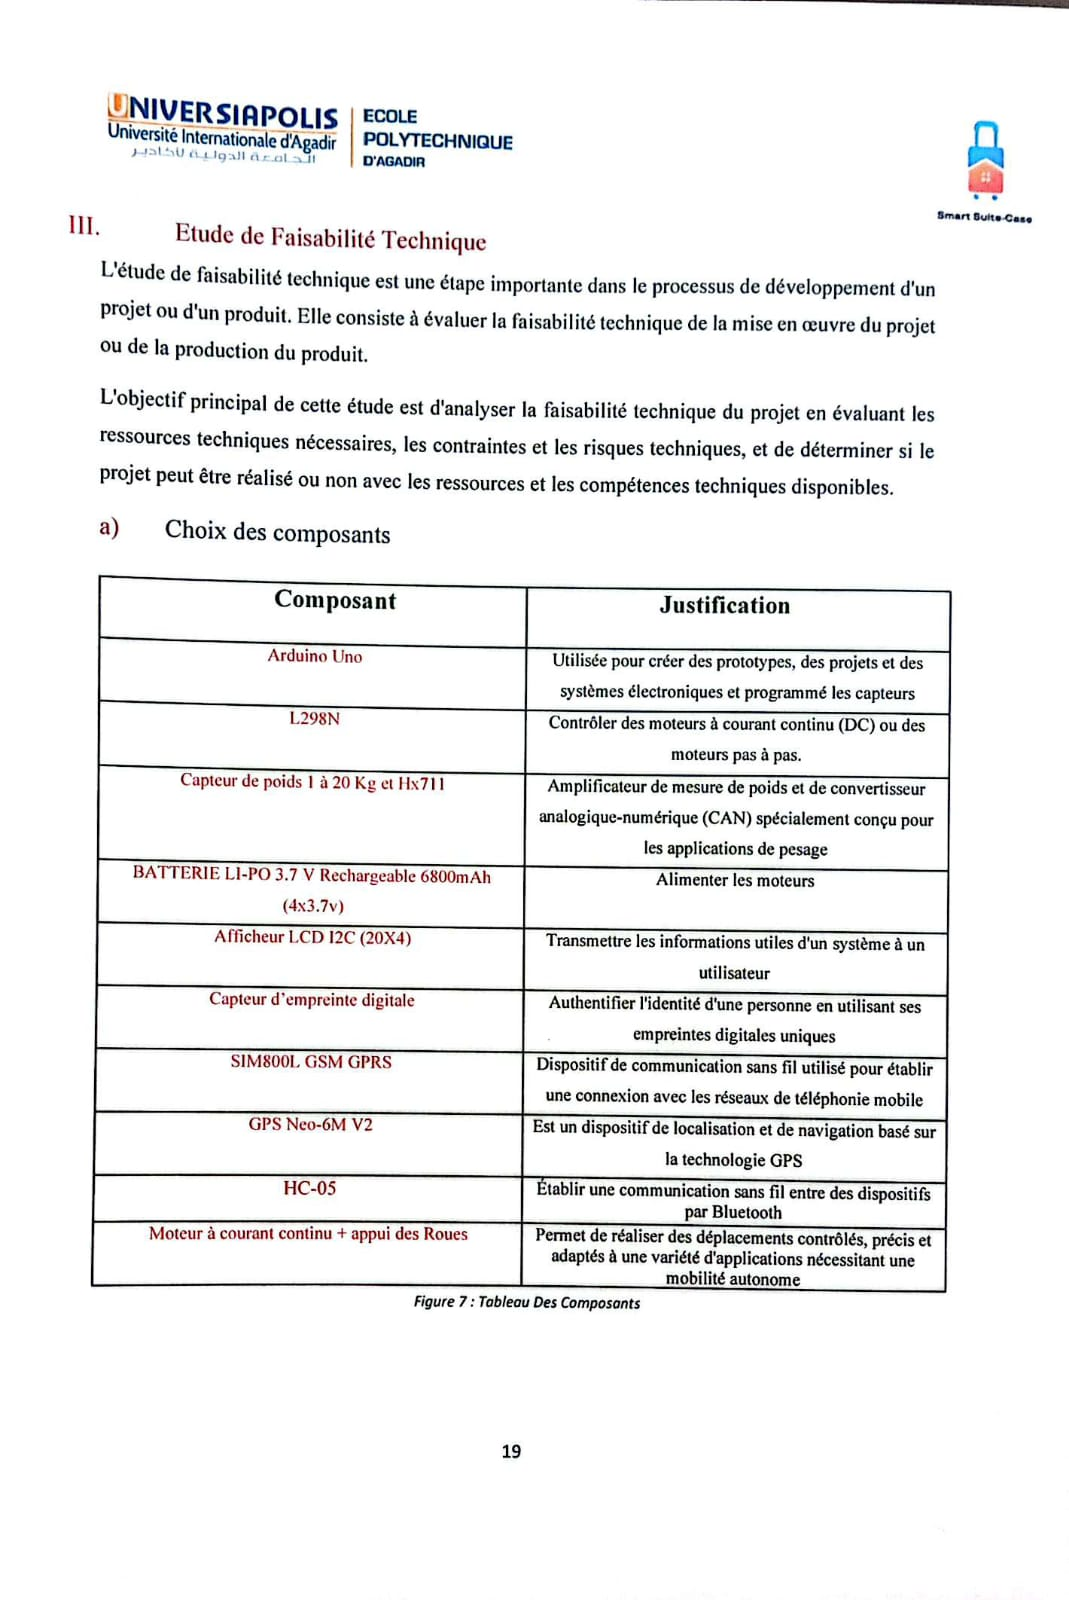

In [ ]:
import numpy as np
import pandas as pd


import pytesseract
from pytesseract import Output
from ultralyticsplus import YOLO, render_result
from PIL import Image #pillow

image = 'test4.jpg'
img = Image.open(image)
img

Ultralytics YOLOv8.0.21 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU
Model summary (fused): 218 layers, 25840918 parameters, 0 gradients, 78.7 GFLOPs
0: 640x448 1 bordered, 1285.7ms
Speed: 2.8ms pre-process, 1285.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Boxes:  tensor([[9.30000e+01, 5.85000e+02, 9.53000e+02, 1.28200e+03, 9.31892e-01, 0.00000e+00]])


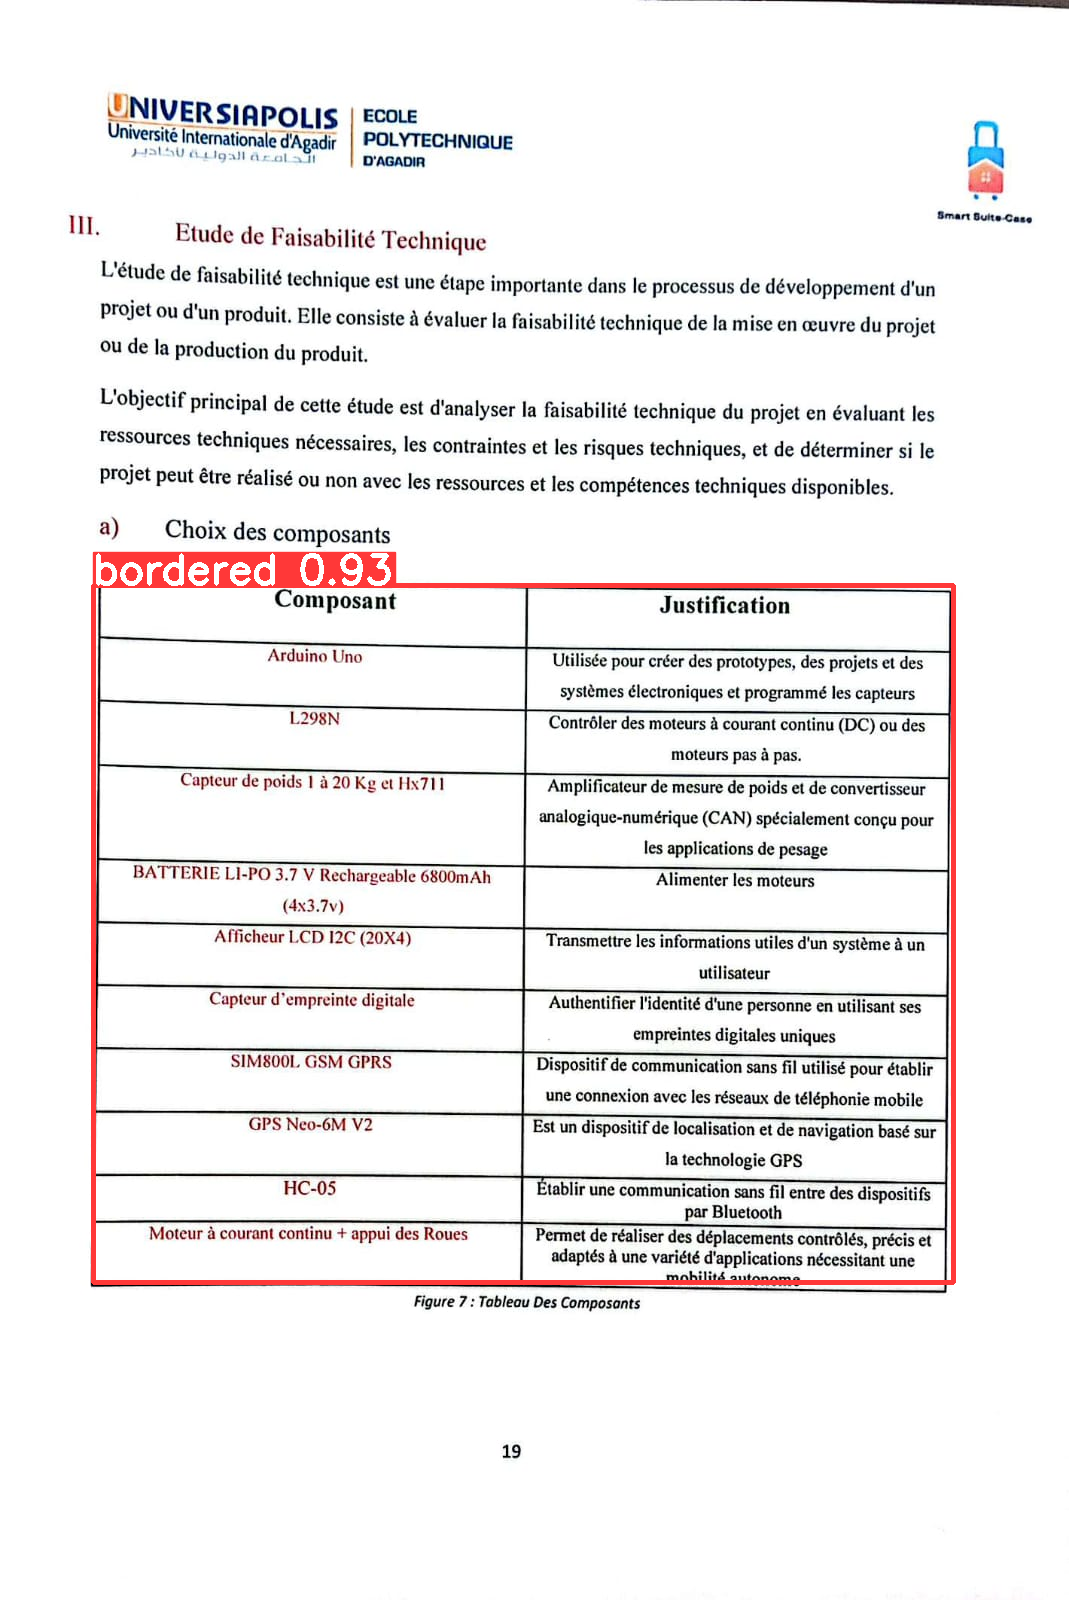

In [ ]:
# load model
model = YOLO('keremberke/yolov8m-table-extraction')

# set model parameters
model.overrides['conf'] = 0.25  # NMS confidence threshold
model.overrides['iou'] = 0.45  # NMS IoU threshold
model.overrides['agnostic_nms'] = False  # NMS class-agnostic
model.overrides['max_det'] = 1000  # maximum number of detections per image

# perform inference
results = model.predict(img)

# observe results
print('Boxes: ', results[0].boxes)
render = render_result(model=model, image=img, result=results[0])
render

In [ ]:
img = np.array(Image.open(image))
tables_vesul=[]
tables=[]

for i in range(len(results[0].boxes.data.numpy())):
  x1, y1, x2, y2, _, _ = tuple(int(item) for item in results[0].boxes.data.numpy()[i]) # (96, 586, 947, 1286)
  x2+=10
  y2+=10
  x1-=10
  y1-=10

  #cropping
  cropped_image = img[y1:y2, x1:x2]
  print(cropped_image.shape)
  tables.append(cropped_image)
  image_tab = Image.fromarray(cropped_image)
  tables_vesul.append(image_tab)


(717, 880, 3)


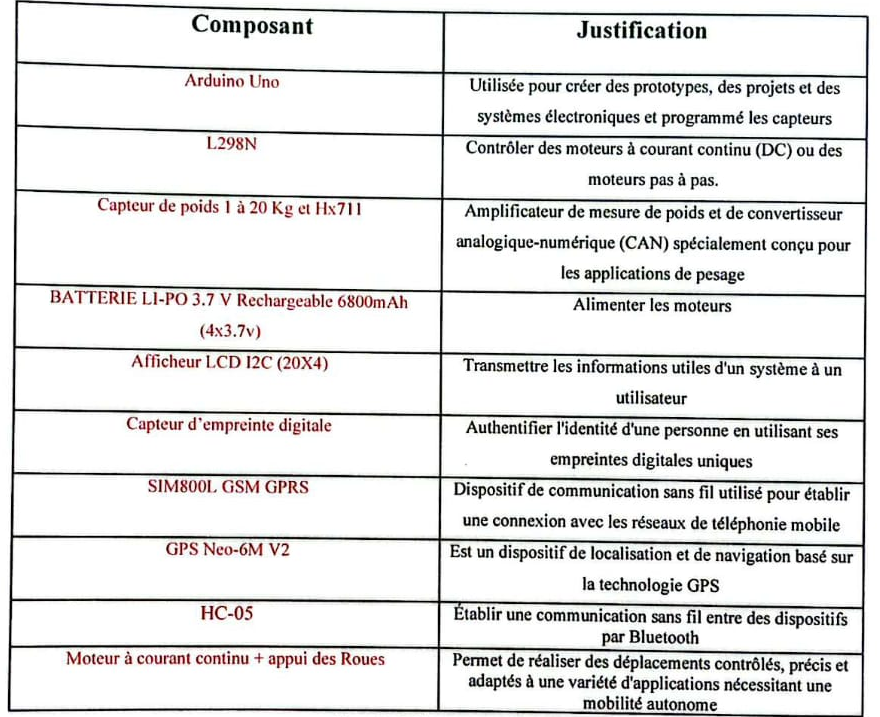

In [ ]:
tables_vesul[0]

# **Step 2 : Table recognition**

# Image Preprpcessing



In [ ]:
import cv2
import subprocess

def add_10_percent_padding(img):
    image_height = img.shape[0]
    padding = int(image_height * 0.1)
    padded_img = cv2.copyMakeBorder(img, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    return padded_img

def img_Preprocessing(img):
  # Grey-scaling
  grayscale_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # converting it to binary image by Thresholding
  thresholded_image = cv2.threshold(grayscale_image, 127, 255, cv2.THRESH_BINARY)[1]
  # Inverting
  inverted_image = cv2.bitwise_not(thresholded_image)
  return inverted_image

def img_Preprocessing_ocr(img):
  # Thresholding
  thresholded_image = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)[1]
  # Inverting
  # inverted_image = cv2.bitwise_not(thresholded_image)
  return thresholded_image

# Combining Vertical And Horizontal Lines
def combine_eroded_images(img):
  # Eroding Vertical Lines
  hor = np.array([[1,1,1,1,1,1]])
  ver_erode_img = cv2.erode(img, hor, iterations=5)
  ver_dilate_img = cv2.dilate(ver_erode_img, hor, iterations=10)
  # Eroding Horizontal Lines
  ver = np.array([[1],[1],[1],[1],[1],[1],[1]])
  hor_erode_img = cv2.erode(img, ver, iterations=5)
  hor_dilate_img = cv2.dilate(hor_erode_img, ver, iterations=10)
  # Combining
  combined_image = cv2.add(ver_dilate_img, hor_dilate_img)
  # dilate combined_image to make lines thicker
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
  combined_image_dilated = cv2.dilate(combined_image, kernel, iterations=5)
  return combined_image_dilated

# Removing The Lines
def subtract_combined_and_dilated_image_from_original_image(processed_img,combined_image_dilated):
    img_without_lines = cv2.subtract(processed_img,combined_image_dilated)
    # remove noise with erode and dilate
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    image_without_lines_noise_removed = cv2.erode(img_without_lines, kernel)
    image_without_lines_noise_removed = cv2.dilate(image_without_lines_noise_removed, kernel)
    return image_without_lines_noise_removed


In [ ]:
"""
  The code below is for visualization purposes only.
"""
# Eroding Vertical Lines
def erode_vertical_lines(img):
  hor = np.array([[1,1,1,1,1,1]])
  ver_erode_img = cv2.erode(img, hor, iterations=10)
  ver_dilate_img = cv2.dilate(ver_erode_img, hor, iterations=10)
  return ver_dilate_img

# Eroding Horizontal Lines
def erode_horizontal_lines(img):
    ver = np.array([[1],[1],[1],[1],[1],[1],[1]])
    hor_erode_img = cv2.erode(img, ver, iterations=10)
    hor_dilate_img = cv2.dilate(hor_erode_img, ver, iterations=5)
    return hor_dilate_img

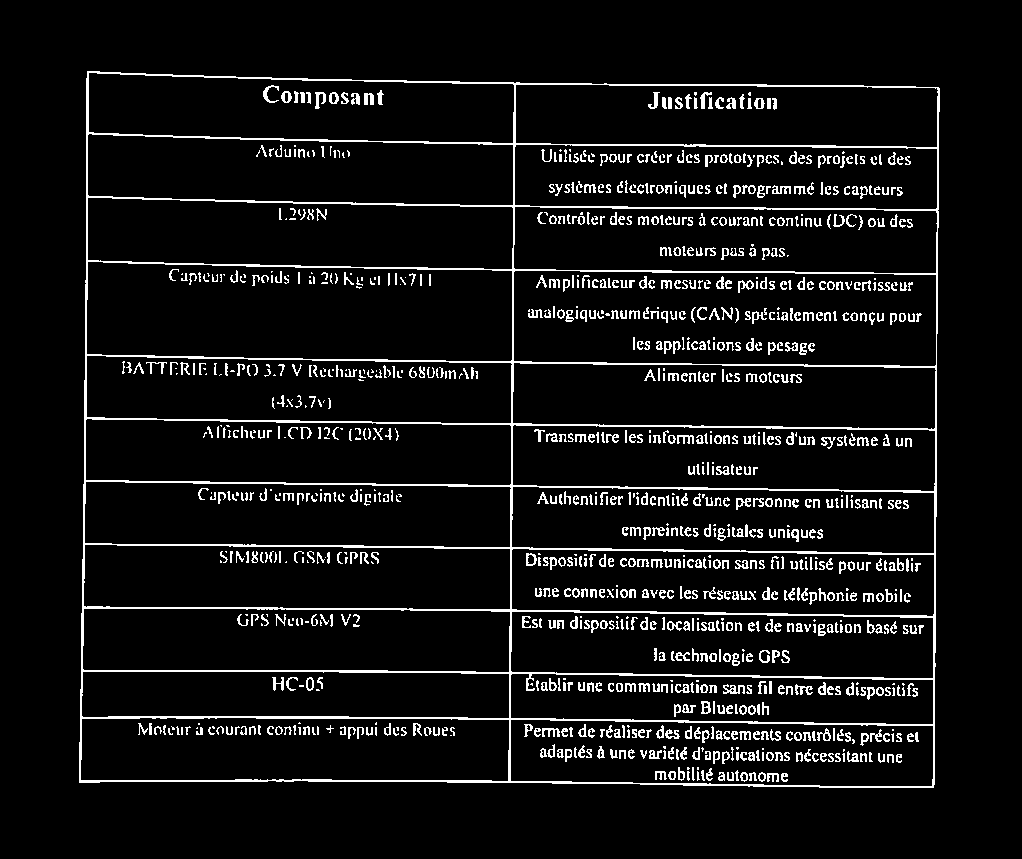

In [ ]:
image_with_padding = add_10_percent_padding(tables[0])
processed_img = img_Preprocessing(image_with_padding)
Image.fromarray(processed_img)


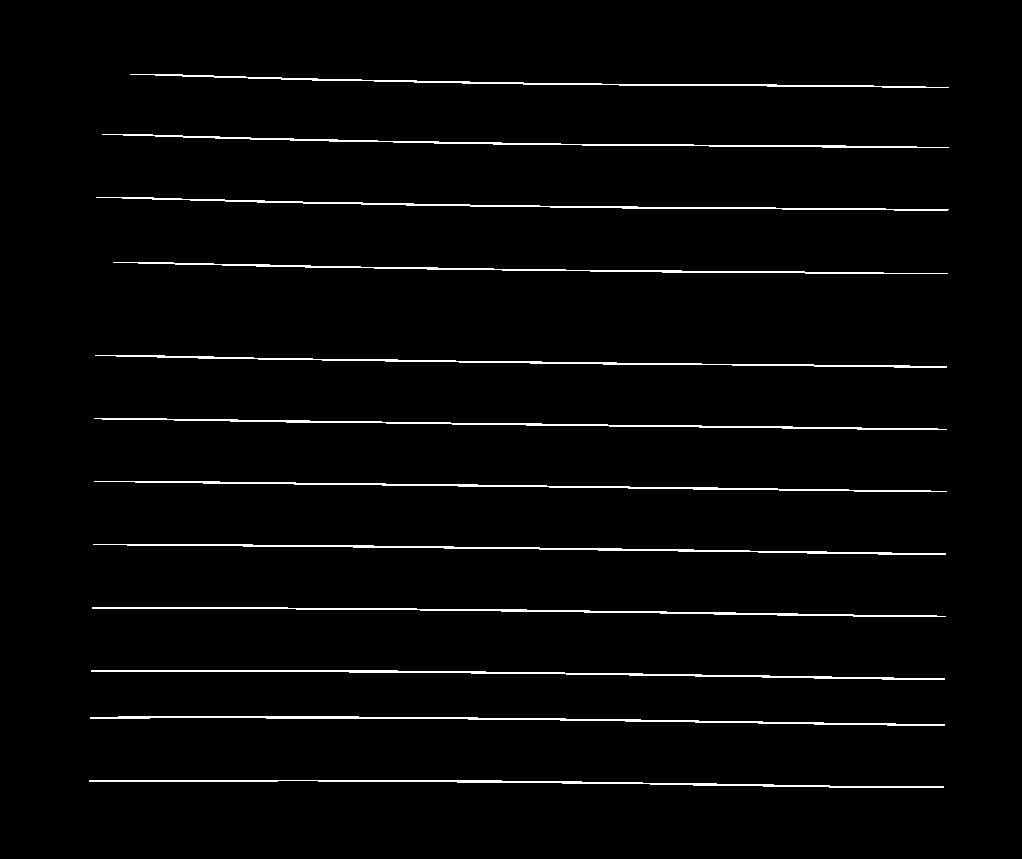

In [ ]:
ver_dilate_img = erode_vertical_lines(processed_img)
Image.fromarray(ver_dilate_img)

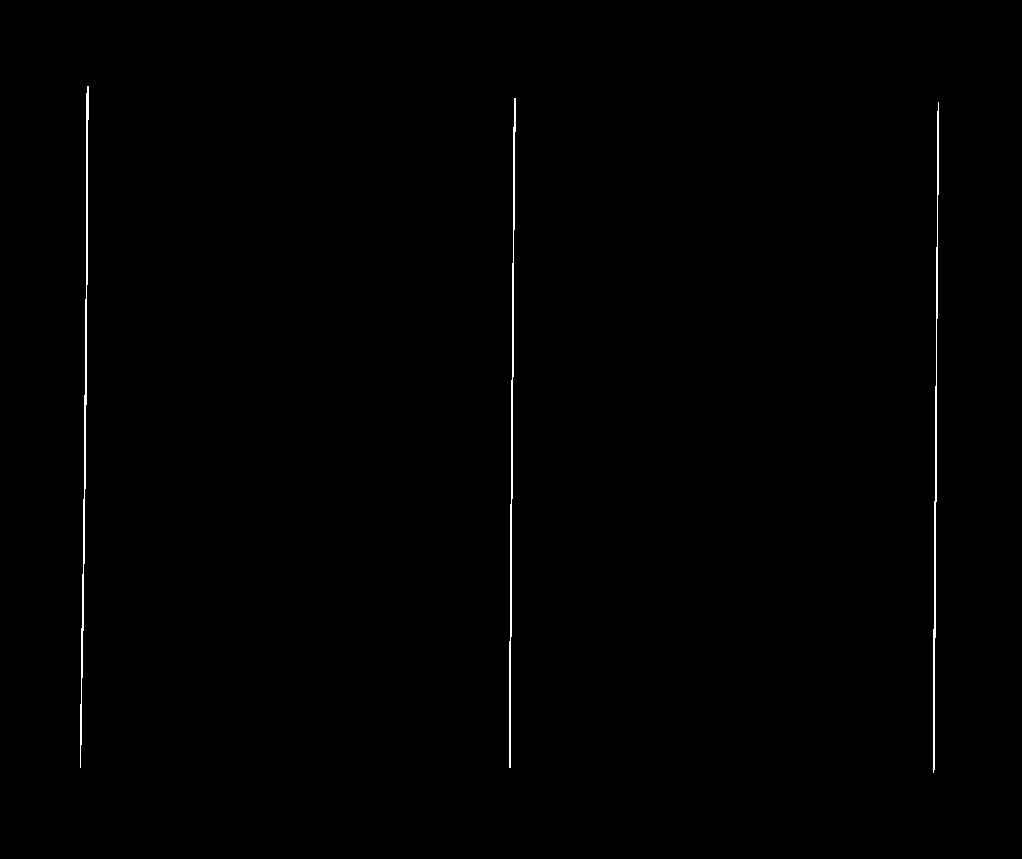

In [ ]:
hor_dilate_img = erode_horizontal_lines(processed_img)
Image.fromarray(hor_dilate_img)

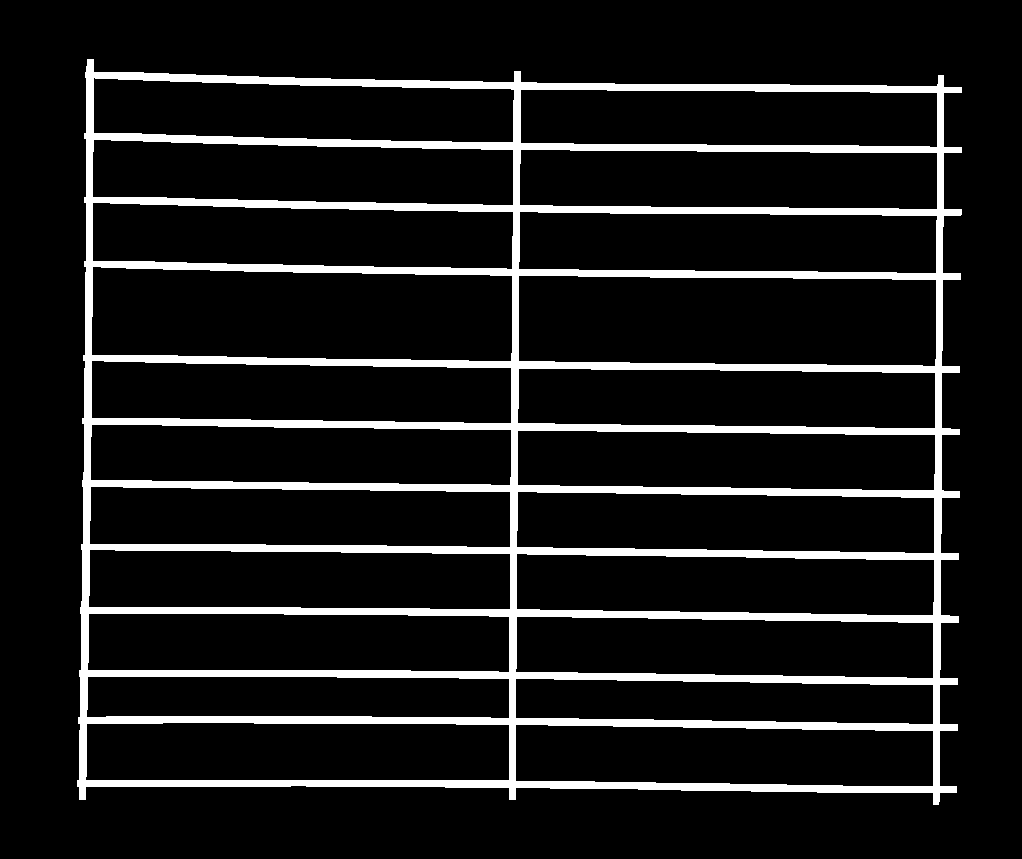

In [ ]:
combined_img = combine_eroded_images(processed_img)
Image.fromarray(combined_img)

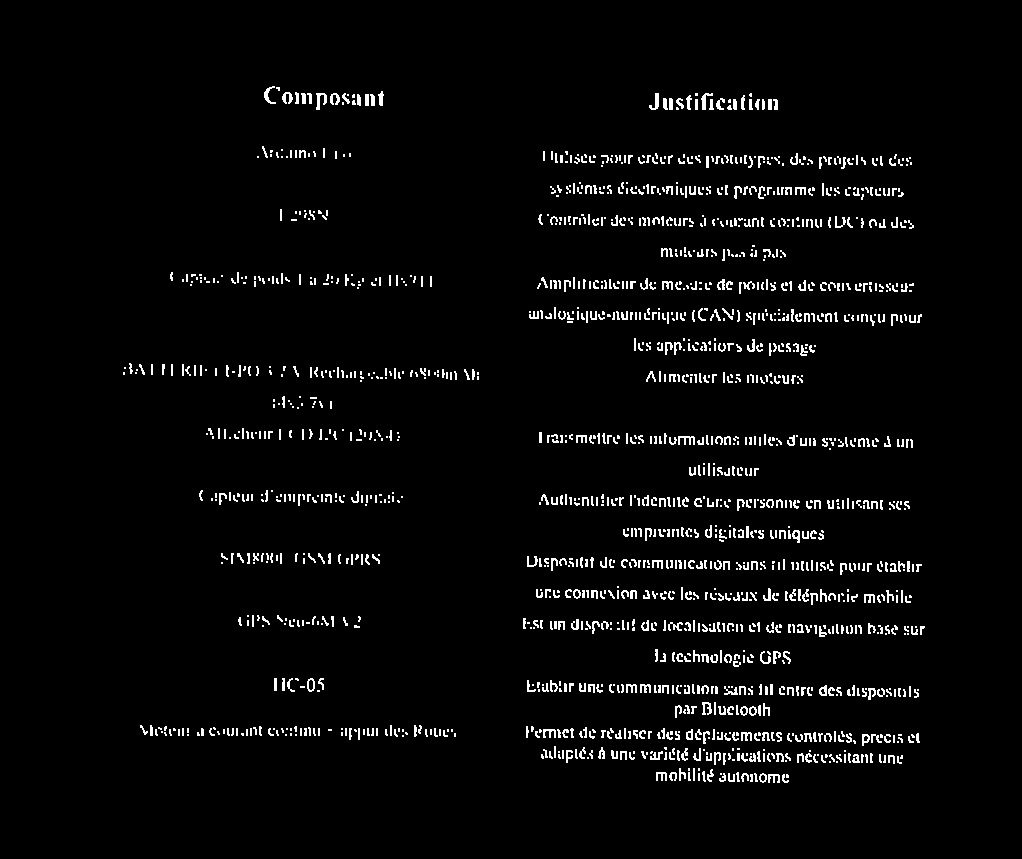

In [ ]:
img_without_lines = subtract_combined_and_dilated_image_from_original_image(processed_img,combined_img)
Image.fromarray(img_without_lines)

# Finding the cells & extracting the text using OCR

In [ ]:
import csv

# Use Dilation To Convert The Words Into Blobs
def dilate_image(thresholded_image):
  kernel_to_remove_gaps_between_words = np.array([[1,1,1,1,1,1,1,1,1,1],[1,1,1,1,1,1,1,1,1,1]])
  dilated_image = cv2.dilate(thresholded_image, kernel_to_remove_gaps_between_words, iterations=5)
  simple_kernel = np.ones((5,5), np.uint8)
  dilated_image = cv2.dilate(dilated_image, simple_kernel, iterations=2)
  return dilated_image

# Find The Contours Of The Blobs
def find_contours(dilated_image,original_image):
    result = cv2.findContours(dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = result[0]
    # The code below is for visualization purposes only.
    image_with_contours_drawn = original_image.copy()
    cv2.drawContours(image_with_contours_drawn,contours, -1, (0, 255, 0), 3)
    return contours,image_with_contours_drawn

# Convert The Blobs Into Bounding Boxes
def convert_contours_to_bounding_boxes(contours,original_image):
    bounding_boxes = []
    image_bounding_boxes = original_image.copy()
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, w, h))
        # The code below is for visualization purposes only.
        image_bounding_boxes = cv2.rectangle(image_bounding_boxes, (x, y), (x + w, y + h), (0, 255, 0), 5)
    return bounding_boxes,image_bounding_boxes

# Sorting The Bounding Boxes By X And Y Coordinates To Make Rows And Columns

def get_mean_height_of_bounding_boxes(bounding_boxes):
    heights = []
    for bounding_box in bounding_boxes:
        x, y, w, h = bounding_box
        heights.append(h)
    return np.mean(heights)

def sort_and_club_all_bounding_boxes_by_similar_y_coordinates_into_rows(bounding_boxes,mean_height):
    # sort_bounding_boxes_by_y_coordinate
    bounding_boxes = sorted(bounding_boxes, key=lambda x: x[1])
    # club_all_bounding_boxes_by_similar_y_coordinates_into_rows
    rows = []
    half_of_mean_height = mean_height / 2
    current_row = [bounding_boxes[0]]
    for bounding_box in bounding_boxes[1:]:
        current_bounding_box_y = bounding_box[1]
        previous_bounding_box_y = current_row[-1][1]
        distance_between_bounding_boxes = abs(current_bounding_box_y - previous_bounding_box_y)
        if distance_between_bounding_boxes <= half_of_mean_height:
            current_row.append(bounding_box)
        else:
            rows.append(current_row)
            current_row = [ bounding_box ]
    rows.append(current_row)

    # sort_all_rows_by_x_coordinate
    for row in rows:
        row.sort(key=lambda x: x[0])


    # Sort rows by the Y coordinate of the first box in each row
    # rows.sort(key=lambda row: row[0][1])

    return rows

# Extracting The Text From The Bounding Boxes Using OCR

def crop_each_bounding_box_and_ocr(rows,original_image):
    table = []
    current_row = []
    image_number = 0
    for row in rows:
        for bounding_box in row:
            x, y, w, h = bounding_box
            # y-=4
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
            image_without_lines_noise_removed = cv2.erode(add_10_percent_padding(original_image[y:y+h, x:x+w]), kernel)
            cropped_image = cv2.dilate(image_without_lines_noise_removed, kernel)
            image_slice_path = "img_" + str(image_number) + ".jpg"
            cv2.imwrite(image_slice_path, cropped_image)
            results_from_ocr = tesseract_results(image_slice_path)
            current_row.append(results_from_ocr)
            image_number += 1
        table.append(current_row)
        current_row = []
    return table

def tesseract_results(image_path):
    # Construct the Tesseract OCR command
    tesseract_command = (
        'tesseract ' + image_path + ' - -l fra+eng --oem 3 --psm 6 --dpi 300 '
    )
    # tesseract_command = ' tesseract  - -l fra+eng  --oem 3 --psm 6 --dpi 300 '

    # Run the Tesseract command using subprocess
    output = subprocess.getoutput(tesseract_command)
    # output = pytesseract.image_to_string(image_path)

    # Strip any leading or trailing whitespace from the output
    output = output.strip('|')
    output = output.replace('\n', ' ')
    output = output.strip()
    return output

# Generating The CSV
"""
def generate_csv_file(talbes):
    with open("output.csv", "w") as f:
        for row in talbes:
            f.write(",".join(row) + "\n")
"""
def generate_csv_file(input_table):
    with open("final_result.csv", 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        for row in input_table:
            csv_writer.writerow(row)

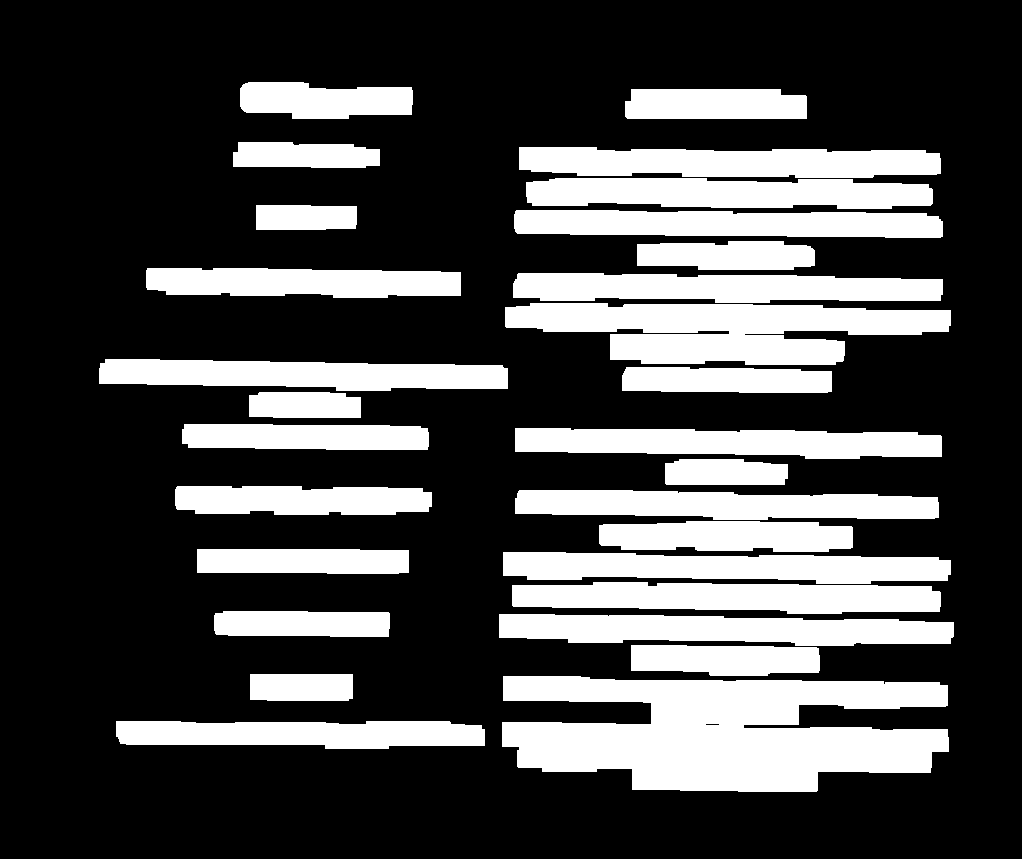

In [ ]:
dilated_img = dilate_image(img_without_lines)
Image.fromarray(dilated_img)

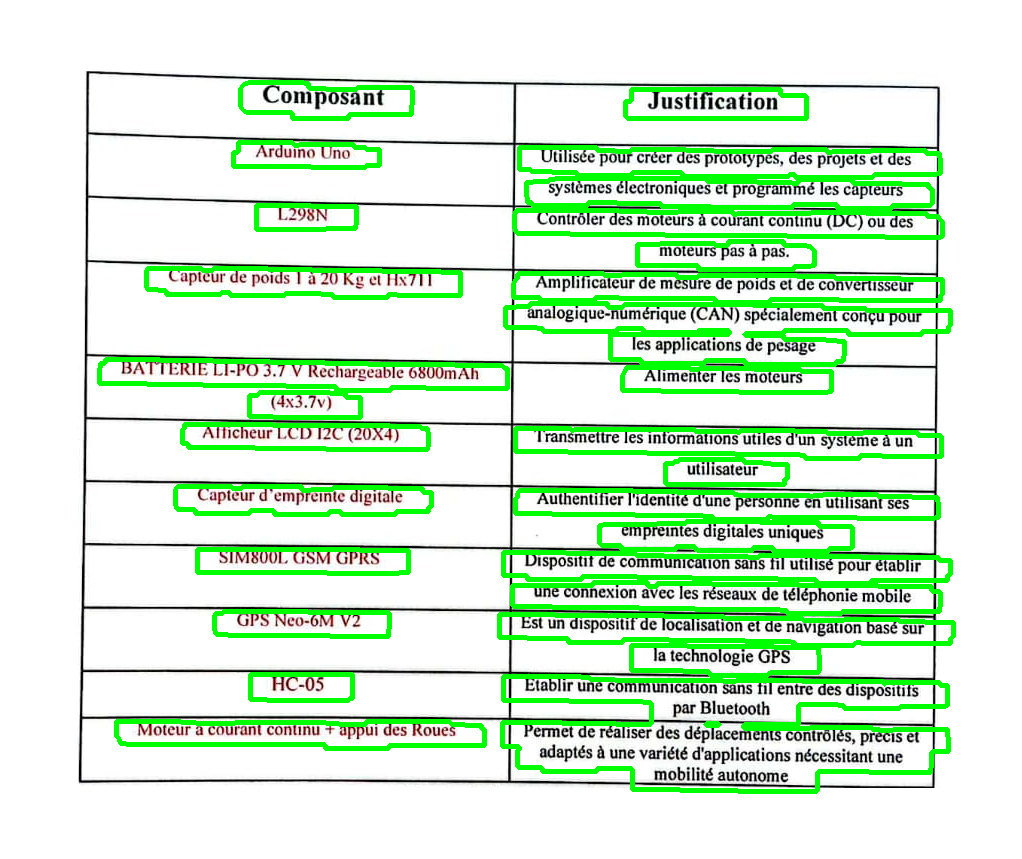

In [ ]:
contours,image_with_contours_drawn = find_contours(dilated_img,image_with_padding)
Image.fromarray(image_with_contours_drawn)


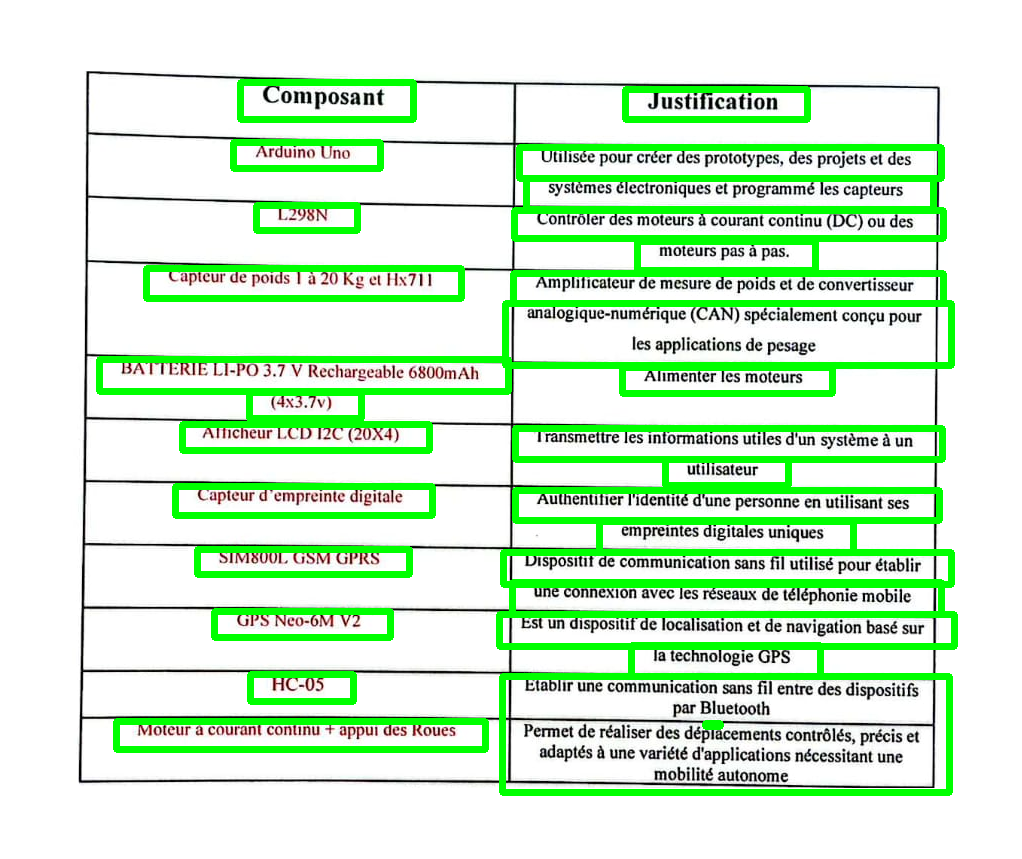

In [ ]:
bounding_boxes,img_bouding_boxes = convert_contours_to_bounding_boxes(contours,image_with_padding)
Image.fromarray(img_bouding_boxes)


In [ ]:
mean_height = get_mean_height_of_bounding_boxes(bounding_boxes)
sorted_rows = sort_and_club_all_bounding_boxes_by_similar_y_coordinates_into_rows(bounding_boxes,mean_height)
table = crop_each_bounding_box_and_ocr(sorted_rows,image_with_padding)
generate_csv_file(table)

In [128]:
table


[['Composant', 'Justification'],
 ['Arduino Uno', 'Utilisée pour créer des prototypes, des projets et des'],
 ['systèmes électroniques et programmé les capteurs'],
 ['L298N', 'Contrôler des moteurs à courant continu (DC) ou des'],
 ['moteurs pas à pas.'],
 ['Capteur de poids 1 à 20 Kg et Hx711',
  'Amplificateur de mesure de poids et de convertisseur'],
 ['analogique-numérique (CAN) spécialement conçu pour les applications de pesage'],
 ['BATTERIE LI-PO 3.7 V Rechargeable 6800mAh', 'Alimenter les moteurs'],
 ['(4x3.7v)'],
 ['Afficheur LCD 12C (20X4)',
  "Transmettre les informations utiles d'un système à un"],
 ['utilisateur'],
 ["Capteur d'empreinte digitale",
  "Authentifier l'identité d'une personne en utilisant ses"],
 ['empreintes digitales uniques'],
 ['SIM800L GSM GPRS',
  'Dispositif de communication sans fil utilisé pour établir'],
 ['une connexion avec les réseaux de téléphonie mobile |'],
 ['GPS Neo-6M V2',
  'Est un dispositif de localisation et de navigation basé sur'],
 [

# Result

In [130]:
final_data = pd.read_csv("final_result.csv")
final_data

Composant  \
0                                         Arduino Uno   
1    systèmes électroniques et programmé les capteurs   
2                                               L298N   
3                                  moteurs pas à pas.   
4                 Capteur de poids 1 à 20 Kg et Hx711   
5   analogique-numérique (CAN) spécialement conçu ...   
6           BATTERIE LI-PO 3.7 V Rechargeable 6800mAh   
7                                            (4x3.7v)   
8                            Afficheur LCD 12C (20X4)   
9                                         utilisateur   
10                       Capteur d'empreinte digitale   
11                       empreintes digitales uniques   
12                                   SIM800L GSM GPRS   
13  une connexion avec les réseaux de téléphonie m...   
14                                      GPS Neo-6M V2   
15                                 la technologie GPS   
16                                              HC-05   
17         Moteur à courant continu + appui des Roues   

                                        Justification  
0   Utilisée pour créer des prototypes, des projet...  
1                                                 NaN  
2   Contrôler des moteurs à courant continu (DC) o...  
3                                                 NaN  
4   Amplificateur de mesure de poids et de convert...  
5                                                 NaN  
6                               Alimenter les moteurs  
7                                                 NaN  
8   Transmettre les informations utiles d'un systè...  
9                                                 NaN  
10  Authentifier l'identité d'une personne en util...  
11                                                NaN  
12  Dispositif de communication sans fil utilisé p...  
13                                                NaN  
14  Est un dispositif de localisation et de naviga...  
15                                                NaN  
16  Établir une communication sans fil entre des d...  
17                                                NaN

# Solution 2 to detect the Table in the image

In [ ]:
# !pip install img2table


In [ ]:
"""
from img2table.document import Image

# Instantiation of the image
img = Image(src="test4.jpg")

# Table identification
imgage_tables = img.extract_tables()

# Result of table identification
imgage_tables
"""

'\nfrom img2table.document import Image\n\n# Instantiation of the image\nimg = Image(src="test4.jpg")\n\n# Table identification\nimgage_tables = img.extract_tables()\n\n# Result of table identification\nimgage_tables\n'